In [1]:
from dfLoader import *
from dataAug import *
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    fig.set_size_inches(3, 10)
    plt.show(block=False)


In [27]:
def getDataLoader(batchSize,ifAug,ifTrain):

    dfList = []

    if ifTrain:
        audioDic = trainAudioDic
    else:
        audioDic = testAudioDic

    for annName in audioDic:
        annPath = '../annotations/' + annName
        audioPath = '../audio/' + audioDic[annName]
        df = dfLoader(annPath, audioPath)
        dfList.append(df)

    finalDF = pd.concat(dfList)
    return finalDF


def trimAudio(df, audio_dir):
    trimmed_data = []


    for filename in df['id'].unique():
        fs, x = wavfile.read(audio_dir + filename)
        fileDuration = x.shape[0]/fs
        spec = gen_mag_spectrogram(x, 1024, 840) # TODO do i have to change 840 to 939 ?
        
        for index, row in df[df['id'] == filename].iterrows():
            startNum = int(row['trimInTime'] / fileDuration * spec.shape[1]) - 4
            endNum   = int(row['trimOutTime'] / fileDuration * spec.shape[1]) - 4
            trimmed_spec = spec[0:spec.shape[0],startNum:endNum]
            if(trimmed_spec.shape[1] == 33):
                trimmed_spec = trimmed_spec[0:trimmed_spec.shape[0],0:32]
    #         if((trimmed_spec.shape[1] != 33) and (trimmed_spec.shape[1] != 32)):
    #             continue
            trimmed_data.append(trimmed_spec)

    return trimmed_data

In [28]:
ann_path = '../annotations/BritishBatCalls_MartynCooke_2018_1_sec_train_expert.json'
audio_dir = '../audio/bat_data_martyn_2018/'

In [29]:
 # Load annotation and convert to dataframe
data = json.load(open(ann_path))
df = pd.json_normalize(data, record_path=['annotation'], meta=['id'])

trimInTime, trimOutTime = calInOutTime(df)
df['trimInTime'] = trimInTime
df['trimOutTime'] = trimOutTime

trimmed_specs = trimAudio(df, audio_dir)
df['data'] = trimmed_specs

specLength = []
for index, row in df.iterrows():
    specLength.append(row['data'].shape[1])
df['len'] = specLength

# Delete data shorter than 20 ms
df = df[df['len'] ==32]

numLabels = addNumLabels(df)
df['label'] = numLabels

resizedSpecs = reSizeSpec(df)
df['data'] = resizedSpecs

KeyboardInterrupt: 

In [30]:
data = json.load(open(ann_path))
df = pd.json_normalize(data, record_path=['annotation'], meta=['id'])

trimInTime, trimOutTime = calInOutTime(df)
df['trimInTime'] = trimInTime
df['trimOutTime'] = trimOutTime

In [31]:
trimmed_specs = trimAudio(df, audio_dir)


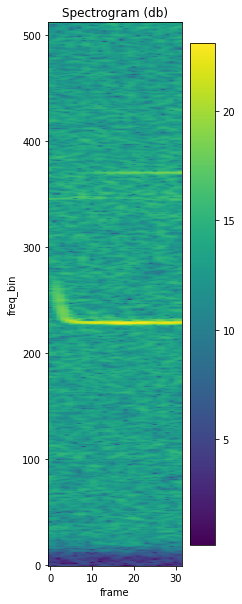

In [32]:
plot_spectrogram(trimmed_specs[5500])

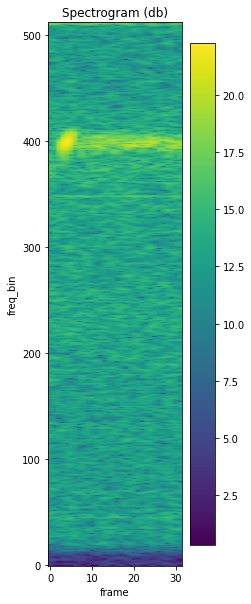

In [33]:
plot_spectrogram(trimmed_specs[10])